In [1]:
#installing packages
!pip install -q --upgrade pip
!pip install -q sentence-transformers faiss-cpu pillow pytesseract pdfplumber PyMuPDF transformers accelerate timm
# whisper for audio transcription
!pip install -q whisper
!pip install -q streamlit
# optional local LLM bindings
!pip install -q llama-cpp-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'whisper' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'whisper'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
pip show whisper


Name: whisper
Version: 1.1.10
Summary: Fixed size round-robin style database
Home-page: http://graphiteapp.org/
Author: Chris Davis
Author-email: chrismd@gmail.com
License: Apache Software License 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: six
Required-by: 


In [3]:
# install official OpenAI Whisper
!pip install -U openai-whisper

# optional: install faster-whisper as fallback
!pip install -U faster-whisper

# install ffmpeg (Colab/linux) so audio formats work
!apt-get update -qq && apt-get install -y -qq ffmpeg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 12.9 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=6c65963b3e7e03d8695321a810dbd3da77e940539664d196b58164d9e7ffb646
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 46.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 41.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [faster-whisper]
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/u

In [4]:
# Imports and global objects
import os
import io
import json
import faiss
import numpy as np
from PIL import Image
import pytesseract
import pdfplumber
import fitz # PyMuPDF
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

# BLIP imports from Hugging Face transformers
from transformers import BlipProcessor, BlipForConditionalGeneration

# Optional whisper import -transcribe audio
try:
  import whisper
  WHISPER_AVAILABLE = True
except Exception:
  WHISPER_AVAILABLE = False

In [5]:
if WHISPER_AVAILABLE:
    print("Whisper is available, you can transcribe audio.")
else:
    print("Whisper not installed, skipping audio transcription")



Whisper is available, you can transcribe audio.


In [6]:
# Model setup (embeddings, BLIP captioner, generator)
# Embeddings
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBED_MODEL_NAME)
EMBED_DIM = embedder.get_sentence_embedding_dimension()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# BLIP captioning (Hugging Face transformers)
BLIP_MODEL_NAME = "Salesforce/blip-image-captioning-base"
processor_blip = BlipProcessor.from_pretrained(BLIP_MODEL_NAME)
model_blip = BlipForConditionalGeneration.from_pretrained(BLIP_MODEL_NAME)



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [8]:
# Generator (RAG synthesis) - flan-t5-small by default (fast)
GEN_MODEL = "google/flan-t5-small"
tokenizer_gen = AutoTokenizer.from_pretrained(GEN_MODEL)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL)
generator = pipeline("text2text-generation", model=gen_model, tokenizer=tokenizer_gen)



tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu


In [9]:
# FAISS index + metadata
index = faiss.IndexFlatL2(EMBED_DIM)      # L2 distance FAISS index
metadatas = []                             # Store metadata for each chunk
embeddings_store = []                     # Store embeddings for each chunk

In [10]:
# Reset FAISS Index
def reset_index():
    """Clears FAISS index, metadata, and stored embeddings."""
    global index, metadatas, embeddings_store
    index = faiss.IndexFlatL2(EMBED_DIM)
    metadatas = []
    embeddings_store = []
    print("Index, metadata, and embeddings reset.")

In [11]:
#Text chunking, embedding, ingestion helpers
def chunk_text(text: str, chunk_size: int = 400, overlap: int = 50):
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        chunk_words = words[i:i+chunk_size]
        chunks.append(" ".join(chunk_words))
        i += chunk_size - overlap
    return chunks



In [12]:
def embed_and_add(text: str, metadata: dict):
    vec = embedder.encode(text, convert_to_numpy=True)
    embeddings_store.append(vec)
    metadatas.append({**metadata, "text": text})
    index.add(np.expand_dims(vec, axis=0))


In [13]:
def ingest_text_string(text: str, source: str = "text_string"):
    chunks = chunk_text(text)
    for i, ch in enumerate(chunks):
        embed_and_add(ch, {"source": source, "type": "text", "id": f"{source}::chunk_{i}"})



In [14]:
def ingest_text_file(path: str):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    ingest_text_string(text, source=f"file:{os.path.basename(path)}")



In [15]:
def ingest_pdf(path: str):
    pieces = []
    try:
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                txt = page.extract_text()
                if txt:
                    pieces.append(txt)
    except Exception:
        doc = fitz.open(path)
        for p in doc:
            pieces.append(p.get_text())
    full = "\n\n".join(pieces)
    ingest_text_string(full, source=f"pdf:{os.path.basename(path)}")

In [16]:
 # Image ingestion using HF BLIP + OCR
 def ingest_image(path: str):

   # Uses Hugging Face BLIP (BlipProcessor + BlipForConditionalGeneration  to create an image caption, and Tesseract for OCR. The resulting text is added to the FAISS index.

    try:
        image = Image.open(path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {path}: {e}")
        return

    # BLIP captioning (processor -> model -> decode)
    try:
        inputs = processor_blip(images=image, return_tensors="pt")
        out_ids = model_blip.generate(**inputs, max_length=64)
        caption = processor_blip.decode(out_ids[0], skip_special_tokens=True)
    except Exception as e:
        caption = ""
        print("BLIP captioning failed:", e)

    # OCR via pytesseract (if installed and available)
    try:
        ocr_text = pytesseract.image_to_string(image)
    except Exception as e:
        ocr_text = ""
        # don't raise; OCR is optional

    text_combined = f"Caption: {caption}\nOCR: {ocr_text}".strip()
    ingest_text_string(text_combined, source=f"image:{os.path.basename(path)}")



In [17]:
  #Audio ingestion (optional, Whisper)
def ingest_audio(path: str):
    # 1. Check if whisper is installed/available
    if not WHISPER_AVAILABLE:
        print("Whisper not available. Install whisper to enable audio transcription.")
        return  # Exit early so the rest of the code doesn’t run

    # 2. Load the Whisper model (small is a good balance between speed and accuracy)
    model = whisper.load_model("small")

    # 3. Use Whisper to transcribe the audio file at the given path
    result = model.transcribe(path)

    # 4. Extract only the text part from Whisper’s output
    transcript = result.get("text", "")

    # 5. Send the transcript into your text ingestion pipeline
    ingest_text_string(transcript, source=f"audio:{os.path.basename(path)}")


In [18]:
#  Retrieval & RAG answer
def retrieve(query: str, top_k: int = 5):

    #Retrieve the most relevant documents from the FAISS index given a user query.Args:
       # query (str): The question or text to search for.
       # top_k (int): Number of top results to return (default = 5).
    #Returns:
       # results (list of dict): Each result contains similarity score and metadata.


    # 1. Convert the query into an embedding vector using the same embedder
    qvec = embedder.encode(query, convert_to_numpy=True)

    # 2. If the index is empty (no documents ingested), return an empty list
    if index.ntotal == 0:
        return []

    # 3. Search the FAISS index for the top_k closest embeddings
    #    - D = distances (similarity scores)
    #    - I = indices of the matching documents
    D, I = index.search(np.expand_dims(qvec, axis=0), top_k)

    # 4. Prepare a list to hold the results
    results = []

    # 5. Loop through each distance (dist) and document index (idx)
    for dist, idx in zip(D[0], I[0]):
        # Make sure the index is valid (within our metadata list)
        if idx < len(metadatas):
            meta = metadatas[idx]  # Retrieve metadata for this document
            # Save score + metadata in the results list
            results.append({"score": float(dist), "metadata": meta})

    # 6. Return the ranked results
    return results


In [19]:
def build_rag_prompt(query: str, retrieved: list, max_context_chars: int = 1500):

     #Build a Retrieval-Augmented Generation (RAG) prompt.query: the user question (string)
    # retrieved: list of retrieved results from FAISS (each contains metadata + text)
    # max_context_chars: how much text to keep per retrieved chunk (default 1500 characters)

     #Returns a prompt string to feed into the generator model.


    parts = []  # will store the context snippets from retrieved documents

    # Loop through each retrieved result
    for r in retrieved:
        # Extract the text from the metadata
        t = r["metadata"].get("text", "")

        # If the text is too long, truncate it to max_context_chars
        if len(t) > max_context_chars:
            t = t[:max_context_chars] + "..."

        # Get the source label (e.g., "file:doc.txt", "pdf:report.pdf", "image:pic.png")
        src = r["metadata"].get("source", "unknown")

        # Format the snippet with its source label
        parts.append(f"Source[{src}]:\n{t}")

    # Join all snippets with separators so the model can distinguish them
    context = "\n\n---\n\n".join(parts)

    # Build the final prompt for the LLM
    prompt = (
        f"You are an assistant that answers using only the provided context and general knowledge.\n"
        f"User query: {query}\n\n"
        f"Context:\n{context}\n\n"
        f"Answer concisely and cite sources (use Source[...] labels)."
    )

    return prompt


In [20]:
def answer_query_detailed(query: str, top_k: int = 5, max_new_tokens: int = 300):
    """
    Retrieve relevant chunks, build a RAG prompt, and generate a detailed answer.
    """
    # 1. Retrieve top-k chunks
    retrieved = retrieve(query, top_k=top_k)

    # 2. Deduplicate by source
    seen = set()
    unique_retrieved = []
    for r in retrieved:
        src = r["metadata"].get("source")
        if src not in seen:
            seen.add(src)
            unique_retrieved.append(r)

    # 3. Build a RAG prompt including longer context
    prompt = build_rag_prompt(query, unique_retrieved, max_context_chars=2000)

    # 4. Generate answer with LLM (more controlled and coherent)
    resp = generator(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=5,
        early_stopping=True,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3
    )

    # 5. Extract generated text
    text = resp[0].get("generated_text") or resp[0].get("text") or str(resp[0])

    # 6. Return answer, retrieved chunks, and prompt
    return {"answer": text, "retrieved": unique_retrieved, "prompt": prompt}



In [21]:
#Install required packages
!pip install -q reportlab matplotlib gTTS pillow

# (optional: offline TTS for local machines)
!pip install -q pyttsx3


In [22]:
# CELL 2: Imports & sample content
import os
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import matplotlib.pyplot as plt
from gtts import gTTS      # Google Text-to-Speech (easy in Colab)
from pathlib import Path
from IPython.display import display, Image, Audio, HTML

# Topic-aligned content (PDF text + audio script)
TITLE = "Climate Change Report 2025"
BODY = (
    "Climate change is one of the most pressing global issues. "
    "Rising temperatures are causing glaciers to melt, sea levels to rise, "
    "and extreme weather events to become more frequent. "
    "Charts show that global CO2 emissions are linked directly "
    "to industrial activity and transportation."
)

OUT_DIR = "sample_files"
os.makedirs(OUT_DIR, exist_ok=True)
pdf_path = os.path.join(OUT_DIR, "climate_report.pdf")
img_path = os.path.join(OUT_DIR, "climate_chart.png")
audio_path = os.path.join(OUT_DIR, "climate_summary.mp3")


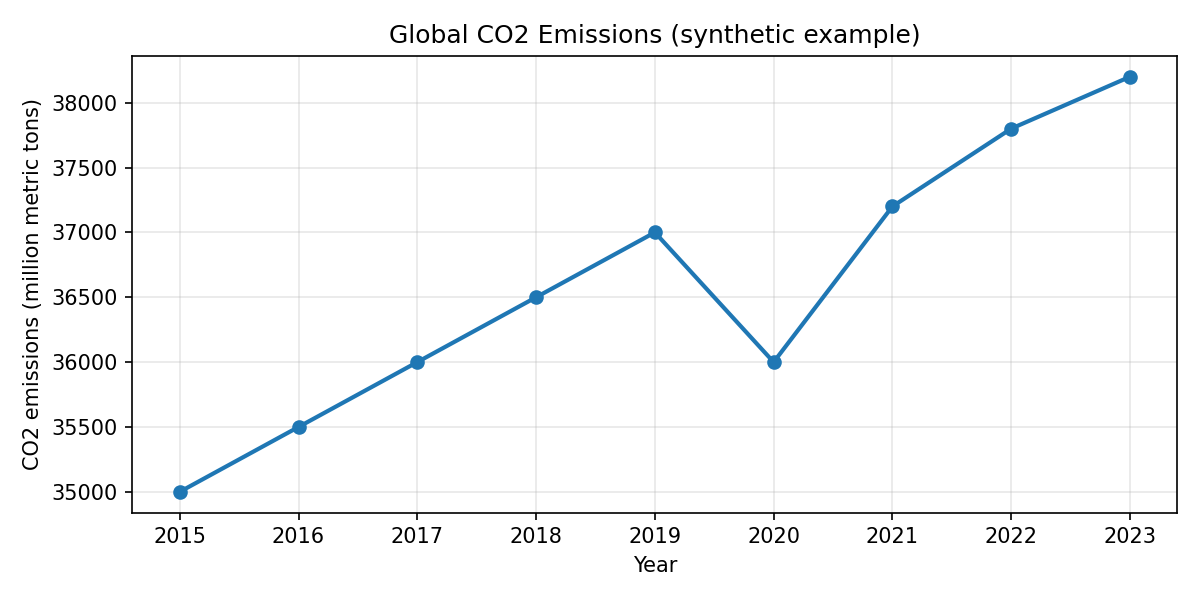

Saved chart to sample_files/climate_chart.png


In [23]:
# CELL 3: Generate a simple CO2 emissions chart and save as PNG
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
# synthetic example data (millions of metric tons)
co2_emissions = [35000, 35500, 36000, 36500, 37000, 36000, 37200, 37800, 38200]

plt.figure(figsize=(8,4))
plt.plot(years, co2_emissions, marker='o', linewidth=2)
plt.title("Global CO2 Emissions (synthetic example)")
plt.xlabel("Year")
plt.ylabel("CO2 emissions (million metric tons)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(img_path, dpi=150)
plt.close()

# show the image preview (in Colab)
display(Image(filename=img_path))
print("Saved chart to", img_path)


In [25]:
# CELL 4: Create a PDF that includes the text and chart image, with download link
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
from IPython.display import display, HTML

# Create a PDF canvas
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4  # get page width and height

# Add the title
c.setFont("Helvetica-Bold", 16)
c.drawString(40, height - 80, TITLE)

# 2. Add the body text with manual wrapping
c.setFont("Helvetica", 11)
text_obj = c.beginText(40, height - 110)
words = BODY.split()
lines = []
line = ""

# Wrap lines roughly at 90 characters
for w in words:
    if len(line) + len(w) + 1 > 90:
        lines.append(line)
        line = w
    else:
        line = (line + " " + w).strip()
if line:
    lines.append(line)

# Write lines to PDF
for ln in lines:
    text_obj.textLine(ln)
c.drawText(text_obj)

# Insert the chart image below the text
try:
    img = ImageReader(img_path)
    max_w = width - 80  # maximum width for image
    iw, ih = img.getSize()
    scale = min(max_w / iw, 300 / ih)  # scale proportionally to fit
    draw_w, draw_h = iw * scale, ih * scale
    c.drawImage(img, 40, height - 110 - draw_h - 20, width=draw_w, height=draw_h)
except Exception as e:
    print("Failed to embed image in PDF:", e)

# Finalize and save PDF
c.showPage()
c.save()
print("Saved PDF to:", pdf_path)

# Display a working download link in Colab
display(HTML(f"<a href='{pdf_path}' download target='_blank'>Click here to download the PDF</a>"))



Saved PDF to: sample_files/climate_report.pdf


In [26]:
# CELL 5: Create an audio narration using gTTS (Google TTS)
tts = gTTS(text=f"{TITLE}. {BODY}", lang="en")
tts.save(audio_path)
print("Saved audio to", audio_path)

# play audio inline (Colab)
display(Audio(audio_path, autoplay=False))


Saved audio to sample_files/climate_summary.mp3


In [38]:
from PIL import Image

img = Image.open("/content/sample_files/climate_chart.png")
img.show()


In [27]:
#Demo
if __name__ == "__main__":
    # Reset FAISS and metadata
    reset_index()  # clears index, metadatas, embeddings

    # Ingest files (replace with actual paths in Colab)
    ingest_pdf('/content/sample_files/climate_report.pdf')       # PDF document
    ingest_image('/content/sample_files/climate_chart.png')      # Image chart
    ingest_audio('/content/sample_files/climate_summary.mp3')    # Audio (if Whisper is available)

    # Ask a query based on ingested knowledge
    out = answer_query_detailed(
        "What does the climate report say about CO2 emissions?",
        top_k=5
    )

    # Print results
    print("Answer:", out["answer"])
    print("Retrieved sources:", [r["metadata"]["source"] for r in out["retrieved"]])



Index, metadata, and embeddings reset.
Error opening image /content/sample_files/climate_chart.png: type object 'Image' has no attribute 'open'


100%|███████████████████████████████████████| 461M/461M [00:11<00:00, 43.2MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Answer: global CO2 emissions are linked directly to industrial activity and transportation
Retrieved sources: ['pdf:climate_report.pdf', 'audio:climate_summary.mp3']
